In [771]:
# Тестовое задание для банка "Норвик банк"
# Должность - Cпециалист по машинному обучению и анализу данных
# Автор - Корнилов А.В.
# Дата - 18.12.2024

In [772]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import bisect
import xml.etree.ElementTree as ET
from datetime import timedelta

In [773]:
# Забираем данные по тарфиам на обслуживание банкоматов
fees = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/fees.parquet')

In [774]:
fees

,ATM_ID,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee
0,ATM_1,1365.0,0.0001,NaN,NaN,NaN,NaN
1,ATM_2,1365.0,0.0001,NaN,NaN,NaN,NaN
2,ATM_4,5250.0,0.0004,450.0,0.0,0.0045,1140.0
3,ATM_3,2250.0,0.0001,675.0,NaN,NaN,NaN


In [775]:
fees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ATM_ID                       4 non-null      string 
 1   CashDeliveryFixedFee         4 non-null      float64
 2   CashDeliveryPercentageFee    4 non-null      float64
 3   CashDeliveryMinFee           2 non-null      float64
 4   CashCollectionFixedFee       1 non-null      float64
 5   CashCollectionPercentageFee  1 non-null      float64
 6   CashCollectionMinFee         1 non-null      float64
dtypes: float64(6), string(1)
memory usage: 352.0 bytes


In [776]:
# статистика операция по дням.
transactions = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/transactions.parquet')

In [777]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0
1,2024-01-12 00:00:00+00:00,ATM_2,0.0,0.0,0.0
2,2024-01-12 00:00:00+00:00,ATM_3,0.0,0.0,0.0
3,2024-01-12 00:00:00+00:00,ATM_4,0.0,0.0,0.0
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0
...,...,...,...,...,...
1171,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0
1172,2024-10-31 00:00:00+00:00,ATM_1,3215500.0,0.0,171600.0
1173,2024-10-31 00:00:00+00:00,ATM_2,4754600.0,0.0,395100.0
1174,2024-10-31 00:00:00+00:00,ATM_3,2277000.0,0.0,1000.0


In [778]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype                  
---  ------          --------------  -----                  
 0   date            1176 non-null   datetime64[ms, Etc/UTC]
 1   ATM_ID          1176 non-null   string                 
 2   bal_end_of_day  1176 non-null   float64                
 3   cash_in         1176 non-null   float64                
 4   cash_out        1176 non-null   float64                
dtypes: datetime64[ms, Etc/UTC](1), float64(3), string(1)
memory usage: 46.1 KB


In [779]:
transactions['date'] = pd.to_datetime(transactions['date'])
max_date = transactions['date'].max() + timedelta(days=1)
min_date = transactions['date'].min() - timedelta(days=1)

In [780]:
max_date = max_date.strftime('%Y-%m-%dT%H:%M:%S')
min_date = min_date.strftime('%Y-%m-%dT%H:%M:%S')

In [781]:
print(f'max_дата = {min_date}\nmin_дата = {max_date}')

max_дата = 2024-01-11T00:00:00
min_дата = 2024-11-01T00:00:00


Часть 1 — упущенный процентный доход

зашьем хардом необходимые данные для запроса на сайт ЦБ
необходимо вынести в отдельные файлы config, но для наглядности оставим в коде

In [782]:
url = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx"

In [783]:
headers = {
    'Host': 'www.cbr.ru',
    'Content-Type': 'text/xml; charset=utf-8',
    'SOAPAction': '"http://web.cbr.ru/KeyRate"',
}

In [784]:
body = f"""<?xml version="1.0" encoding="utf-8"?>
<soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/">
  <soap:Body>
    <KeyRate xmlns="http://web.cbr.ru/">
      <fromDate>{min_date}</fromDate>
      <ToDate>{max_date}</ToDate>
    </KeyRate>
  </soap:Body>
</soap:Envelope>"""

In [785]:
response = requests.post(url, data=body, headers=headers)

соберу в словарь инфо. по ключ. ставке и дате

In [786]:
if response.status_code == 200:
    RateDate = {}
    xml_response = response.text
    root = ET.fromstring(xml_response)
    for kr in root.findall('.//KR'):
        date = kr.find('DT').text
        rate = kr.find('Rate').text
        RateDate[date] = rate

In [787]:
RateDate

{'2024-11-01T00:00:00+03:00': '21.00',
 '2024-10-31T00:00:00+03:00': '21.00',
 '2024-10-30T00:00:00+03:00': '21.00',
 '2024-10-29T00:00:00+03:00': '21.00',
 '2024-10-28T00:00:00+03:00': '21.00',
 '2024-10-25T00:00:00+03:00': '19.00',
 '2024-10-24T00:00:00+03:00': '19.00',
 '2024-10-23T00:00:00+03:00': '19.00',
 '2024-10-22T00:00:00+03:00': '19.00',
 '2024-10-21T00:00:00+03:00': '19.00',
 '2024-10-18T00:00:00+03:00': '19.00',
 '2024-10-17T00:00:00+03:00': '19.00',
 '2024-10-16T00:00:00+03:00': '19.00',
 '2024-10-15T00:00:00+03:00': '19.00',
 '2024-10-14T00:00:00+03:00': '19.00',
 '2024-10-11T00:00:00+03:00': '19.00',
 '2024-10-10T00:00:00+03:00': '19.00',
 '2024-10-09T00:00:00+03:00': '19.00',
 '2024-10-08T00:00:00+03:00': '19.00',
 '2024-10-07T00:00:00+03:00': '19.00',
 '2024-10-04T00:00:00+03:00': '19.00',
 '2024-10-03T00:00:00+03:00': '19.00',
 '2024-10-02T00:00:00+03:00': '19.00',
 '2024-10-01T00:00:00+03:00': '19.00',
 '2024-09-30T00:00:00+03:00': '19.00',
 '2024-09-27T00:00:00+03:

In [788]:
# Преобразование ключей словаря в формат datetime
interest_rates = {pd.to_datetime(k): v for k, v in RateDate.items()}

In [789]:
def calculate_lost_interest_profit(row):
    date = row['date']
    bal_end_of_day = row['bal_end_of_day']

    for rate_date in sorted(interest_rates.keys()):
        if date.strftime('%Y-%m-%d') == rate_date.strftime('%Y-%m-%d'):
            rate = interest_rates[rate_date]
            return bal_end_of_day * float(rate)/100  # Рассчитываем прибыль по проценту

    return None

In [790]:
transactions['LostInterestProfit'] = transactions.apply(calculate_lost_interest_profit, axis=1)

In [791]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype                  
---  ------              --------------  -----                  
 0   date                1176 non-null   datetime64[ms, Etc/UTC]
 1   ATM_ID              1176 non-null   string                 
 2   bal_end_of_day      1176 non-null   float64                
 3   cash_in             1176 non-null   float64                
 4   cash_out            1176 non-null   float64                
 5   LostInterestProfit  824 non-null    float64                
dtypes: datetime64[ms, Etc/UTC](1), float64(4), string(1)
memory usage: 55.2 KB


!!! Исходя из полученных данных, а именно в поле LostInterestProfit заполненно только 824 ячейки, а данные могут быть в дальнейшем использованы для решения задачи ML
заполним поля по правилу, что если для данной даты между соседями не было изменения ставки вносим ее. 
Изменим код функции calculate_lost_interest_profit

In [792]:
def calculate_lost_interest_profit(row):
    date = row['date']
    bal_end_of_day = row['bal_end_of_day']
    
    sorted_dates = sorted(interest_rates.keys())

    if date in interest_rates:
        rate = interest_rates[date]
        return bal_end_of_day * float(rate) / 100 /365

    pos = bisect.bisect_left(sorted_dates, date)

    lower_date = sorted_dates[pos - 1] if pos > 0 else None
    upper_date = sorted_dates[pos] if pos < len(sorted_dates) else None

    if lower_date and upper_date:
        if lower_date in interest_rates and upper_date in interest_rates:
             return bal_end_of_day * float(interest_rates[lower_date]) / 100
    return None

In [793]:
transactions['LostInterestProfit'] = transactions.apply(calculate_lost_interest_profit, axis=1)

теперь пропусков нет, все значения заполнены

In [794]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype                  
---  ------              --------------  -----                  
 0   date                1176 non-null   datetime64[ms, Etc/UTC]
 1   ATM_ID              1176 non-null   string                 
 2   bal_end_of_day      1176 non-null   float64                
 3   cash_in             1176 non-null   float64                
 4   cash_out            1176 non-null   float64                
 5   LostInterestProfit  1176 non-null   float64                
dtypes: datetime64[ms, Etc/UTC](1), float64(4), string(1)
memory usage: 55.2 KB


In [795]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,LostInterestProfit
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.0
1,2024-01-12 00:00:00+00:00,ATM_2,0.0,0.0,0.0,0.0
2,2024-01-12 00:00:00+00:00,ATM_3,0.0,0.0,0.0,0.0
3,2024-01-12 00:00:00+00:00,ATM_4,0.0,0.0,0.0,0.0
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1171,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0,157006.5
1172,2024-10-31 00:00:00+00:00,ATM_1,3215500.0,0.0,171600.0,675255.0
1173,2024-10-31 00:00:00+00:00,ATM_2,4754600.0,0.0,395100.0,998466.0
1174,2024-10-31 00:00:00+00:00,ATM_3,2277000.0,0.0,1000.0,478170.0


Часть 2 - расходы на инкассацию

для удобство заменю все nan на нули

In [796]:
fees.fillna(0, inplace=True)
transactions.fillna(0, inplace=True)

рассчитаем затрады на доставку и замену касет

In [797]:
CashDelivery = ['CashDeliveryFixedFee', 'CashDeliveryPercentageFee', 'CashDeliveryMinFee', 'cash_in']
CashCollection = ['CashCollectionFixedFee', 'CashCollectionPercentageFee', 'CashCollectionMinFee', 'bal_end_of_day']

In [798]:
def calculate_cash_delivery_fee(row, CashInfo):
    atm_fees = fees[fees['ATM_ID'] == row['ATM_ID']]
    
    fixed_fee = atm_fees[CashInfo[0]].values[0]
    percentage_fee = atm_fees[CashInfo[1]].values[0]
    min_fee = atm_fees[CashInfo[2]].values[0]
    
    delivery_amount = row[CashInfo[3]]
    fee = fixed_fee + max(min_fee, delivery_amount * percentage_fee)
    
    return fee

In [799]:
transactions['delivery_fee'] = transactions.apply(lambda row: calculate_cash_delivery_fee(row, CashDelivery), axis=1)
transactions['collection_fee'] = transactions.apply(lambda row: calculate_cash_delivery_fee(row, CashCollection), axis=1)

In [800]:
transactions['incassation_costs'] = transactions['delivery_fee'] + transactions['collection_fee']

In [801]:
transactions.drop(columns=['delivery_fee', 'collection_fee'], inplace=True)

In [802]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,LostInterestProfit,incassation_costs
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.0,1365.000
1,2024-01-12 00:00:00+00:00,ATM_2,0.0,0.0,0.0,0.0,1365.000
2,2024-01-12 00:00:00+00:00,ATM_3,0.0,0.0,0.0,0.0,2925.000
3,2024-01-12 00:00:00+00:00,ATM_4,0.0,0.0,0.0,0.0,6840.000
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.0,1365.000
...,...,...,...,...,...,...,...
1171,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0,157006.5,9064.425
1172,2024-10-31 00:00:00+00:00,ATM_1,3215500.0,0.0,171600.0,675255.0,1365.000
1173,2024-10-31 00:00:00+00:00,ATM_2,4754600.0,0.0,395100.0,998466.0,1365.000
1174,2024-10-31 00:00:00+00:00,ATM_3,2277000.0,0.0,1000.0,478170.0,2925.000


Часть 3 - анализ данных

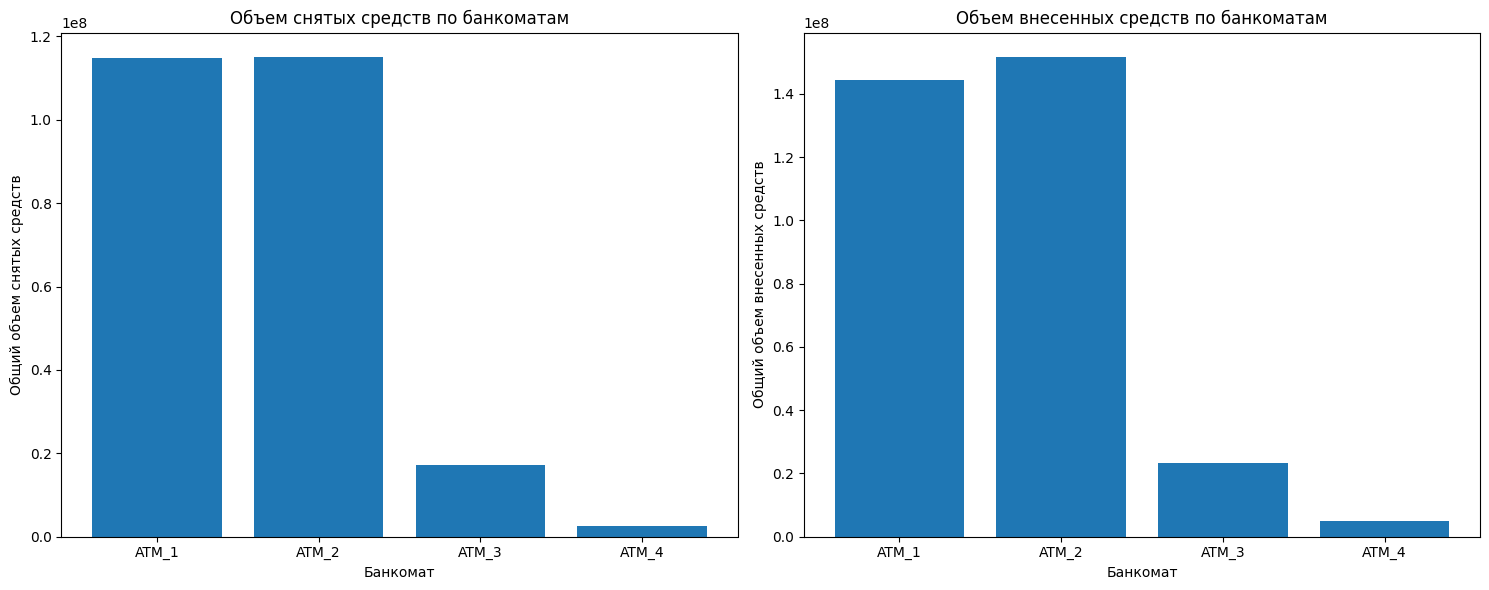

In [803]:
# Подсчитаем общий объем снятых и внесенных средств для каждого банкомата
total_withdrawals = transactions.groupby('ATM_ID')['cash_out'].sum()

total_deposits = transactions.groupby('ATM_ID')['cash_in'].sum()
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].bar(total_withdrawals.index, total_withdrawals.values)
ax[0].set_xlabel('Банкомат')
ax[0].set_ylabel('Общий объем снятых средств')
ax[0].set_title('Объем снятых средств по банкоматам')

ax[1].bar(total_deposits.index, total_deposits.values)
ax[1].set_xlabel('Банкомат')
ax[1].set_ylabel('Общий объем внесенных средств')
ax[1].set_title('Объем внесенных средств по банкоматам')

plt.tight_layout()
plt.show()

In [804]:
average_values = transactions.groupby('ATM_ID')[['bal_end_of_day', 'cash_out', 'LostInterestProfit', 'incassation_costs']].mean().reset_index()

In [805]:
average_values

,ATM_ID,bal_end_of_day,cash_out,LostInterestProfit,incassation_costs
0,ATM_1,3.666365e+06,390943.877551,616044.265306,1414.129252
1,ATM_2,3.999686e+06,391734.693878,671333.353741,1416.612245
2,ATM_3,2.776978e+06,58422.789116,459502.619048,2925.000000
3,ATM_4,1.074001e+06,8677.210884,179597.931973,10554.452041


Часть 4 - меняем бизнес с помощью ML

Так как, данная часть немного сложнее и требует передачи моей мысли, буду стараться оставлять комменатарий больше

In [806]:
# Рассчитаем среднее снятие и стандартное отклонение для снятий (cash_out) по каждому банкомату
transactions['cash_out_mean'] = transactions.groupby('ATM_ID')['cash_out'].transform('mean')
transactions['cash_out_std'] = transactions.groupby('ATM_ID')['cash_out'].transform('std')

In [807]:
# Уровень сервиса 90% (доверительный интервал для 90%)
confidence_level = 0.9
z_score = 1.28  # Для 90% доверительного интервала (https://mse.msu.ru/wp-content/uploads/2020/03/%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F-5-%D0%B4%D0%BE%D0%B2%D0%B5%D1%80%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D0%B2%D0%B0%D0%BB%D1%8B.pdf)

In [808]:
# Рассчитываем необходимый баланс для 90% уровня сервиса
transactions['required_balance'] = transactions['cash_out_mean'] + z_score * transactions['cash_out_std']

In [809]:
# Стратегия пополнения:
# Если текущий остаток меньше требуемого, пополняем
transactions['needs_replenishment'] = transactions['bal_end_of_day'] < transactions['required_balance']

In [810]:
# Сколько денег нужно пополнить
transactions['replenishment_amount'] = np.maximum(0, transactions['required_balance'] - transactions['bal_end_of_day'])

In [811]:
# Рассчитаем издержки на инкасацию и потери от упущенной выгоды
transactions['total_cost'] = transactions.get('incassation_costs', 0) + transactions.get('LostInterestProfit', 0)

In [812]:
# Пример расчета пополнений на 3 дня вперед (планирование с учетом времени доставки)
transactions['replenishment_plan'] = transactions['replenishment_amount'].shift(3)  # 3 дня на доставку

In [813]:
# Сравнение с базовой стратегией (пополнение по среднему снятию)
transactions['base_replenishment'] = transactions['cash_out_mean']

In [814]:
# Рассчитаем уровень сервиса на основе текущих данных
service_level = (transactions['bal_end_of_day'] >= transactions['cash_out']).mean()  # Доля дней, когда хватало для снятия

<Figure size 1000x600 with 0 Axes>

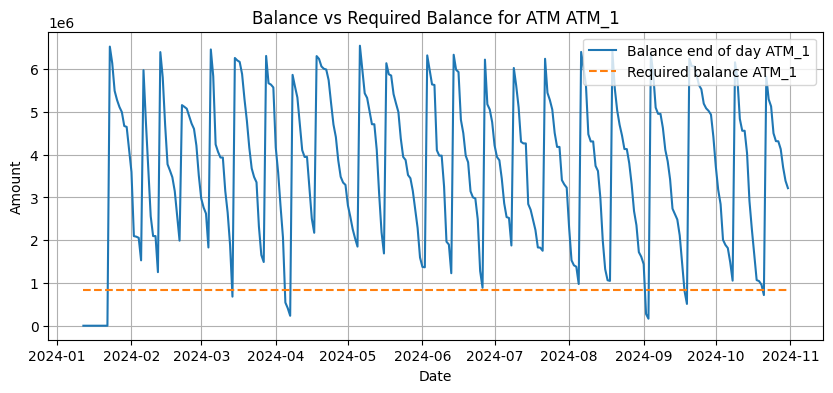

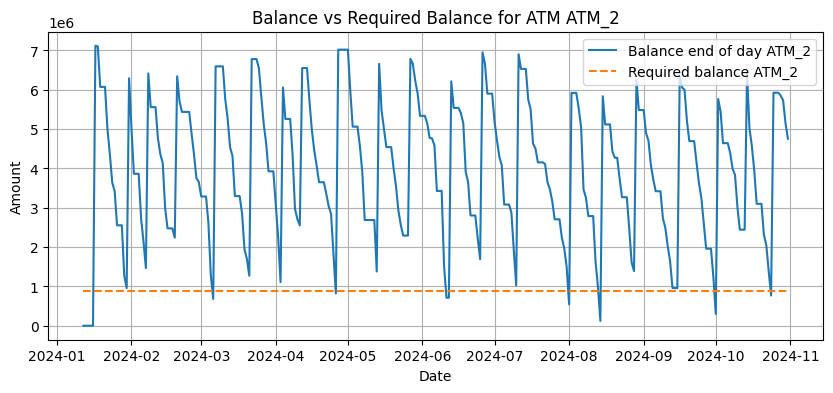

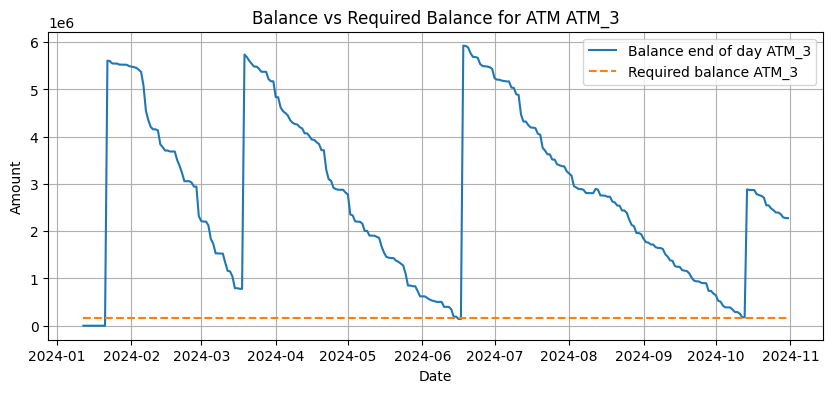

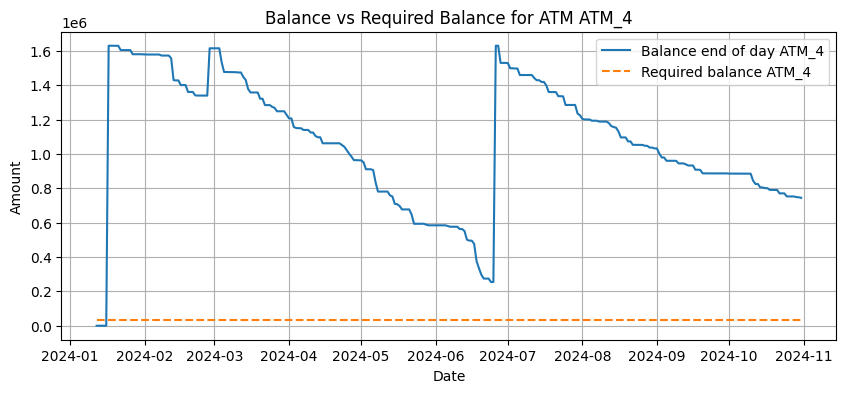

In [815]:
# Визуализация и ретро-тестирование результатов
atm_ids = transactions['ATM_ID'].unique()

plt.figure(figsize=(10, 6))

for atm_id in atm_ids:
    plt.figure(figsize=(10, 4))
    atm_data = transactions[transactions['ATM_ID'] == atm_id]
    plt.plot(atm_data['date'], atm_data['bal_end_of_day'], label=f'Balance end of day {atm_id}')
    plt.plot(atm_data['date'], atm_data['required_balance'], label=f'Required balance {atm_id}', linestyle='--')
    
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.title(f'Balance vs Required Balance for ATM {atm_id}')
    plt.legend()
    plt.grid()
    plt.show()

После тестирования предложенного мной варианта, делаю выводу:
    1. Модель работает эффективно, уровен сервиса выше 90%
    2. Близки к оптимальным(на мой взгляд) расчитаные показатели для пополнения банкомата с учетом потерь процентов и комиссии инкасаторов 
